In [495]:
%matplotlib inline

# For interactivity
# %matplotlib widget

# All imports
from random import choice
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import ipywidgets as widgets

# Set number of decimal places to show
np.set_printoptions(formatter={'float': '{:.4f}'.format})

In [496]:
def sigmoid(x: float) -> float:
    """Returns the sigmoid

    Args:
        x (float): the input

    Returns:
        float: the sigmoid of the input
    """
    return 1./(1. + np.exp(-x))

def sigmoid_prime(x: float) -> float:
    """Return the derivative of the sigmoid function

    Args:
        x (float): the input (after being sigmoid'ed)

    Returns:
        float: the derivative of the sigmoid of the input
    """
    return x*(1.-x)

def tanh(x: float) -> float:
    """Returns the hyperbolic tangent

    Args:
        x (float): input

    Returns:
        float: hyperbolic tangent of x
    """
    return ((np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x)))

def tanh_prime(x: float) -> float:
    """Returns the derivative of the hyperbolic tangent

    Args:
        x (float): x = tanh(y), ie x must be tanh(some input)

    Returns:
        float: derivative of the hyperbolic tangent of x
    """
    return (1. - x**2)

In [497]:
class NeuralNetwork:
    def __init__(self, layers: list, activation: str='sigmoid', verbose=False):
        """Cosntructor for neural network

        Args:
            layers (list): number of inputs, hidden layers, and outputs as a list
            activation (str, optional): activation function to use. Only sigmoid and tanh are available. Defaults to 'signmoid'.
        """
        self.num_layers = len(layers)
        self.num_inputs = layers[0]
        self.num_outputs = layers[-1]
        self.num_hidden_layers = len(layers) - 1
        self.layers = layers
        if verbose:
            print(f"num_inputs = {self.num_inputs}\nnum_outputs = {self.num_outputs}\nlayers = {self.layers}")
        
        # Create random weights
        self.weights = []
        for i in range(self.num_layers - 1):
            # Add bias weight for each neuron if not last layer
            if i == self.num_layers - 1:
                curr_weights = np.random.rand(layers[i], layers[i+1])
            else:
                curr_weights = np.random.rand(layers[i] + 1, layers[i+1])
            self.weights.append(curr_weights)

        if verbose:
            for layer, weights in enumerate(self.weights):
                print(f"weights[{layer}]:\n{weights}")
                print(f"weights[{layer}].shape: {weights.shape}")
                print()
        
        if activation == "sigmoid":
            self.activation = sigmoid
            self.activation_derivative = sigmoid_prime
        elif activation == "tanh":
            self.activation = tanh
            self.activation_derivative = tanh_prime
        else:
            raise Exception("Activation function must be 'sigmoid' or 'tanh'")

        # Array to store post-activations for each layer; for n layers, there are n - 1 activations, as layer n - 1, the output layer,
        # does not have an activation
        self.activations = [np.array([]) for _ in range(self.num_layers - 1)]
        # Array to store inputs for each layer. Last layer's 'input' is the activation of the last hidden layer
        self.inputs = [np.array([]) for _ in range(self.num_layers)]
        self.errors = []
        self.errors_squared = []
        self.is_trained = False

    def forward_prop(self, X: np.ndarray, verbose: bool=False):
        """runs forward propagation through the NN for a given input.

        Args:
            X (np.ndarray): the training sample
            verbose (bool, optional): Flag to print out statement. Defaults to False.

        Returns:
            np.ndarray: The output of the NN
        """
        # Add to inputs array
        X = np.atleast_2d(X) # Convert to 2D matrix
        # Add bias to first input
        X = np.concatenate((X, np.ones((1, 1))), axis=1)
        self.inputs[0] = X
        if verbose:
            print("inputs:", self.inputs[0])
        
        # Forward prop through each layer
        for layer, weight in enumerate(self.weights):
            curr_layer_input = self.inputs[layer]
            
            if verbose:
                print(f"layer {layer}, curr_input.shape: {curr_layer_input.shape}")
                print(f"Layer {layer}, curr_input: {curr_layer_input}")
                print(self.inputs)
            
            dot_product = np.dot(curr_layer_input, weight)
            z_curr_layer = np.atleast_2d(self.activation(dot_product)) # Apply activation function
            
            # Save activation of curr layer
            self.activations[layer] = z_curr_layer
            # Save input to next layer after adding bias if next layer is not output layer
            if not layer == self.num_layers - 2:
                next_layer_input = np.concatenate((z_curr_layer, np.ones((1, 1))), axis=1)
                self.inputs[layer + 1] = next_layer_input
            else:
                self.inputs[layer + 1] = z_curr_layer
        
        if verbose:
            print("activations:")
            print(self.activations)
            print("inputs:")
            print(self.inputs)
        # self.activations has length n - 1. activations[0] is the output of layer 0, so activations[n-2] is the 
        # output of the last hidden layer, aka the output of the NN. Layer n - 1 is the output layer and has no 
        # activations
        return self.activations[-1]
    
    def __backprop(self, alpha: float = 0.02, verbose=False):
        """back propagation method that updates weights for an NN by sampling from 

        Args:
            alpha (float, optional): learning rate. Defaults to 0.02.
            verbose (bool, optional): whether to print out statements. Defaults to False.

        Returns:
            None
        """
        if not self.is_trained:
            raise Exception("backprop can only be called through the fit() method")
        # Keep track of deltas, weight updates, and errors at each pass
        deltas = [np.array([]) for _ in range(self.num_hidden_layers)]
        weight_updates = [np.array([]) for _ in range(self.num_hidden_layers)]
        # Choose a random sample from training data and corresponding target
        sample = np.random.choice(len(self.X))
        curr_sample = self.X[sample]
        curr_target = self.target[sample]

        # Check inputs
        if isinstance(curr_sample, np.ndarray) and not len(curr_sample) == self.num_inputs:
                raise Exception("Number of inputs must match those specified in architecture")
        if isinstance(curr_target, np.ndarray) and not len(curr_target) == self.num_outputs:
                raise Exception("Number of outputs must match those specified in architecture and be supplied as a list")

        # Get output of NN and do backprop for the first hidden layer as its delta is different
        z = self.forward_prop(curr_sample, False)
        if verbose:
            print(z)
        curr_target = np.atleast_2d(curr_target)
        error = np.array(curr_target - z)
        # Save errors 
        self.errors.append(error.squeeze())
        self.errors_squared.append(error**2)

        delta_last = (curr_target - z)*self.activation_derivative(z)
        deltas[-1] = delta_last
        # self.inputs' last element is the NN output, so one before that is the input for the last hidden layer
        delta_weights_output = np.dot(self.inputs[self.num_layers - 2].T, delta_last)*alpha
        weight_updates[-1] = delta_weights_output
        self.weights[-1] += delta_weights_output # Update weights
        
        if verbose:
            print(f"Backprop for layer {self.num_hidden_layers - 1} done\n")
        
        # Start backprop-ing starting from layer (n-3), as layer (n-2) weights have been updated.
        for curr_layer in range(self.num_layers - 3, -1, -1):
            if verbose: 
                print(f"backprop from layer {curr_layer + 1} to {curr_layer} out of {self.num_layers} layers")
            
            # Drop the bias activation value from the next layer, so do not take input of next layer, 
            # just activation of current layer. This is z^(i)
            next_layer_activations = self.activations[curr_layer]
            next_layer_weights = self.weights[curr_layer + 1]
            # Drop the weights of the bias neuron from next layer, as this layer did not have any input into that
            next_layer_weights = next_layer_weights[:-1, :]
            
            # Calculate delta for curr_layer and update weights
            delta_curr_layer = sigmoid_prime(next_layer_activations)*np.dot(deltas[curr_layer + 1], next_layer_weights.T)
            deltas[curr_layer] = delta_curr_layer
            curr_inputs = self.inputs[curr_layer]
            weight_update_curr_layer = alpha*np.dot(curr_inputs.T, delta_curr_layer)
            weight_updates[curr_layer] = weight_update_curr_layer
            self.weights[curr_layer] += weight_update_curr_layer
            
            if verbose: 
                print(f"Backprop for layer {curr_layer} done")
                # print(f"Weight updates:\n{weight_update_curr_layer}")
                print()
        
        return

    def fit(self, X:np.ndarray, y:np.ndarray, learning_rate:float=0.2, steps:float=10**5, tol:float = 10**-2, verbose:bool = False):
        """Method to train a neural network

        Args:
            X (np.ndarray): Training data
            y (np.ndarray): Target data
            learning_rate (float, optional): learning rate of the NN. Defaults to 0.2.
            steps (float, optional): no. steps to train for. Defaults to 10**5.
            tol (float, optional): error value below which training exits. Defaults to 10**-2.
            verbose (bool, optional): Flag to print out statements. Defaults to False.
        """
        if not isinstance(X, np.ndarray) or not X.any():
            raise Exception("Input must be given and be a numpy array")
        if not isinstance(y, np.ndarray) or not y.any():
            raise Exception("Target outputs must be supplied as a numpy array")
        if not len(X) == len(y):
            raise Exception(f"Training data length must match target data length {X.shape} != {y.shape}")
        # Save training data and target data to instance variable
        self.X = X
        self.target = y
        self.is_trained = True
        # Initialize arrays to store RMS_errors and steps_list to update plots
        RMS_errors = []
        steps_list = []
        eval_interval = int(steps*0.1)
        
        # Initialize plot and create widget so output statements aren't cleared when plot updates
        plt.figure()
        plot_out = widgets.Output()
        display.display(plot_out)

        # Begin training
        for iter in range(0, steps + 1):
            self.__backprop(learning_rate, verbose)

            # If we reach 10% of iterations, print out data and show training update
            if iter % eval_interval == 0:
                steps_list.append(iter)
                print(f"Step: {iter}")
                print("Training Results(data, prediction, expected):")
                self.predict_many(self.X, self.target)
                # RMS_error = self.__find_RMS_error_across_all_errors(int(max(0, iter - steps*0.1)))
                RMS_error = self.__find_RMS_error()
                RMS_errors.append(RMS_error)
                print(f"RMS_err: {RMS_error}\n")

                # Plot stuff - clear output, reinitialize labels and titles, and display it
                with plot_out:
                    display.clear_output(wait=True)
                    plt.title("Live update - RMS error over time")
                    plt.xlabel("Training steps")
                    plt.ylabel("RMS error")
                    plt.ylim(0, 1)
                    plt.plot(steps_list, RMS_errors, '-', label="RMS error")
                    plt.legend()
                    display.display(plt.gcf())
                
                # Sleep and clear figure. If something is funky, try increasing sleep interval
                time.sleep(0.1)
                plt.clf()

                # Early exit condition
                if RMS_error <= tol:
                    # Close all figures after training is complete
                    plt.close('all')
                    print("NN training succeded!")
                    return
        # Close all figures after training is complete
        plt.close('all')
        if RMS_error > tol:
            print("NN training failed.")

        return

    def __find_RMS_error(self):
        """private method to find RMS error with current weights
        """
        rms_errors = []
        for i, sample in enumerate(self.X):
            output = self.forward_prop(sample)
            error = self.target[i] - output
            rms_errors.append(error)
        return np.sqrt(np.mean(np.array(rms_errors)**2))
    
    def __find_RMS_error_across_all_errors(self, start_idx: int = 0):
        """Private method to find RMS error across all errors so far

        Args:
            start_idx (int, optional): index to find errors from. Defaults to 0.

        Returns:
            np.ndarray: RMS error array
        """
        if not self.is_trained:
            raise Exception("RMS error can only be calculated through the fit() method")
        return np.sqrt(np.mean(np.array(self.errors[start_idx:])**2))

    def predict(self, x: np.ndarray) -> np.ndarray:
        """Uses the input to predict an output according to NN weights.

        Args:
            x (np.ndarray): input
        """
        return self.forward_prop(x, False)
    
    def predict_many(self, X: np.ndarray, y: np.ndarray):
        """Predict outputs for all X training data with y target.

        Args:
            X (np.ndarray): input
            y (np.ndarray): target
        """
        for i, sample in enumerate(X):
            print(f"{sample}, {self.predict(sample)[0][0]}, {y[i]}")

    def visual_NN_boundaries(self, Nsamp=2000):
        """returns predictions for Nsamp random samples between 0 and 1 inclusive

        Args:
            Nsamp (int, optional): number of samples to test it for. Defaults to 2000.
        """
        predictions = []
        for iter in range(Nsamp):
            input = np.random.rand(1, 2)
            prediction = False if self.predict(input) < 0.5 else True
            predictions.append((input, prediction))
        return predictions

    def __smooth_errors(self, window_size: int=10):
        """Private method to smooth errors over window_size

        Args:
            window_size (int, optional): How many errors to average over. Defaults to 10.

        Returns:
            np.ndarray: smoothed errors
        """
        window = np.ones(window_size) / window_size
        return np.convolve(np.array(self.errors_squared).flatten(), window, mode='valid')

    def get_smoothed_errors_squared(self, window_size=10):
        """Method to get errors_squared and smoothed versions of it

        Args:
            window_size (int, optional): window size to average over. Defaults to 10.

        Returns:
            np.ndarray: errors_squared and smoothed errors
        """
        smoothed_errors = self.__smooth_errors(min(window_size, len(self.errors_squared)))
        return np.array(self.errors_squared), smoothed_errors
    

In [498]:
XOR = NeuralNetwork([2, 2, 1], activation='tanh', verbose=False)

X = np.array([[0, 0],
            [0, 1],
            [1, 0],
            [1, 1]])
y = np.array([0, 1, 1, 0])
steps = 2*10**4
XOR.fit(X, 
         y,
         steps=steps,
         learning_rate=0.33,
         verbose=False)

Output()

Step: 0
Training Results(data, prediction, expected):
[0 0], 0.9221031566450703, 0
[0 1], 0.9374858417089902, 1
[1 0], 0.9528408649511403, 1
[1 1], 0.9563169086138349, 0
RMS_err: 0.6653849008658287



Step: 2000
Training Results(data, prediction, expected):
[0 0], 0.004273919274946339, 0
[0 1], 0.9586710375896442, 1
[1 0], 0.9643879626639433, 1
[1 1], -0.0006941323080482012, 0
RMS_err: 0.02736351833541846



Step: 4000
Training Results(data, prediction, expected):
[0 0], 0.0018615773463026121, 0
[0 1], 0.9730621595781767, 1
[1 0], 0.9833819803396535, 1
[1 1], -5.356554092873258e-06, 0
RMS_err: 0.015853006993408386



Step: 6000
Training Results(data, prediction, expected):
[0 0], 0.0018441431446775808, 0
[0 1], 0.9768810877957151, 1
[1 0], 0.9893793602333641, 1
[1 1], 0.0012176261266668817, 0
RMS_err: 0.012768766266602281



Step: 8000
Training Results(data, prediction, expected):
[0 0], 0.00041407078795972345, 0
[0 1], 0.9789969378392812, 1
[1 0], 0.9922270918329811, 1
[1 1], 4.3438607355768326e-05, 0
RMS_err: 0.011199554266018553



Step: 10000
Training Results(data, prediction, expected):
[0 0], 5.5026324400630646e-06, 0
[0 1], 0.9805708466229413, 1
[1 0], 0.9938783243717566, 1
[1 1], 2.658806355082439e-07, 0
RMS_err: 0.010185368719348834



Step: 12000
Training Results(data, prediction, expected):
[0 0], 0.0015088609831623082, 0
[0 1], 0.981862382886841, 1
[1 0], 0.9951041447308059, 1
[1 1], 0.0002007227023126076, 0
RMS_err: 0.009424164477954881



NN training succeded!


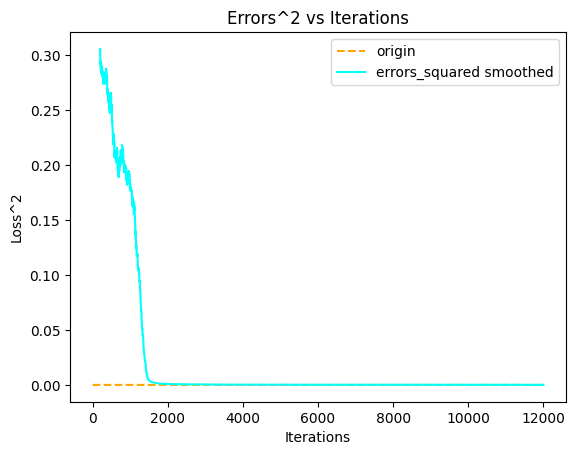

In [499]:
# Show smoothed loss function vs training steps
window_size = max(int(0.01*steps), 1)
errors_squared, smoothed_errors = XOR.get_smoothed_errors_squared(window_size)
errors_squared = errors_squared.flatten()
num_errors = len(errors_squared)
x_errors = np.linspace(0, num_errors, num_errors)
x_smoothed = np.linspace(window_size, num_errors, len(smoothed_errors))
origin = np.zeros(num_errors)
plt.plot(x_errors, origin, '--', label='origin', color='orange')
# plt.plot(x_errors, errors_squared, label="errors_squared raw", color='blue')
plt.plot(x_smoothed, smoothed_errors, label="errors_squared smoothed", color='cyan')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss^2")
plt.title("Errors^2 vs Iterations")
plt.show()
plt.close()

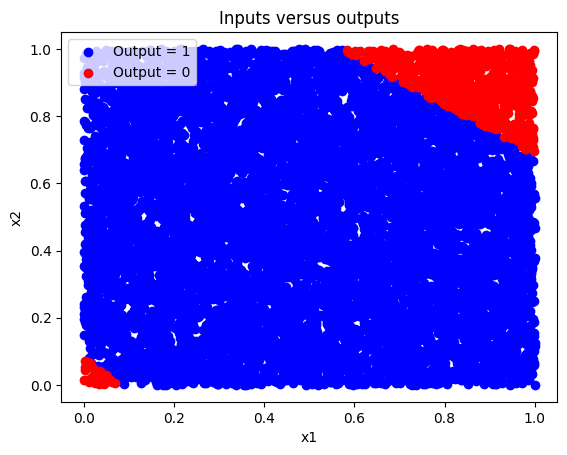

In [500]:
boundary = XOR.visual_NN_boundaries(10000)
inputs, outputs = zip(*boundary)
inputs = np.vstack(inputs)
outputs = np.round(np.vstack(outputs)).astype(int).flatten()
true_inputs, false_inputs = inputs[outputs == 1], inputs[outputs == 0]
plt.scatter(true_inputs[:, 0], true_inputs[:, 1], c='b', marker='o', label='Output = 1')
plt.scatter(false_inputs[:, 0], false_inputs[:, 1], c='r', marker='o', label='Output = 0')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Inputs versus outputs")
plt.legend()
plt.show()
plt.close()

In [501]:
nn = NeuralNetwork([2, 4, 4, 1], activation='sigmoid', verbose=False)

X = np.array([[0, 0],
            [0, 1],
            [0.5, 1],
            [0, 0.5],
            [1, 0],
            [1, 1]])
y = np.array([0, 0, 0, 1, 1, 1])

steps = 2*10**5

nn.fit(X, 
        y,
        steps=steps,
        learning_rate=0.55,
        verbose=False)

Output()

Step: 0
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.7642351076680667, 0
[0.0000 1.0000], 0.76906523413173, 0
[0.5000 1.0000], 0.7706781320173789, 0
[0.0000 0.5000], 0.7668335123879434, 1
[1.0000 0.0000], 0.7683577064709519, 1
[1.0000 1.0000], 0.7720599630501084, 1
RMS_err: 0.5670747806144808



Step: 20000
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.1853523784271053, 0
[0.0000 1.0000], 0.18213074118597522, 0
[0.5000 1.0000], 0.19160141683500057, 0
[0.0000 0.5000], 0.18307674799959126, 1
[1.0000 0.0000], 0.9906399536796876, 1
[1.0000 1.0000], 0.9563594877355012, 1
RMS_err: 0.3590714688478852



Step: 40000
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.14403618422454134, 0
[0.0000 1.0000], 0.22539330140410554, 0
[0.5000 1.0000], 0.04516925224803888, 0
[0.0000 0.5000], 0.27613913656218786, 1
[1.0000 0.0000], 0.9807157217005347, 1
[1.0000 1.0000], 0.9563268885808105, 1
RMS_err: 0.31618628414800926



Step: 60000
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.026397818050826843, 0
[0.0000 1.0000], 0.022562687689647535, 0
[0.5000 1.0000], 0.007945208097253314, 0
[0.0000 0.5000], 0.9700848991213672, 1
[1.0000 0.0000], 0.9861394853433508, 1
[1.0000 1.0000], 0.9821010563652516, 1
RMS_err: 0.02112046920130507



Step: 80000
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.018351872767973954, 0
[0.0000 1.0000], 0.015156443808840984, 0
[0.5000 1.0000], 0.005915688113559013, 0
[0.0000 0.5000], 0.9800454664416226, 1
[1.0000 0.0000], 0.9894817154077304, 1
[1.0000 1.0000], 0.9874024419219833, 1
RMS_err: 0.01454315749017815



Step: 100000
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.015189078464074862, 0
[0.0000 1.0000], 0.012501911401619282, 0
[0.5000 1.0000], 0.005087746034662264, 0
[0.0000 0.5000], 0.9844607094145414, 1
[1.0000 0.0000], 0.9913931699399828, 1
[1.0000 1.0000], 0.990044142734678, 1
RMS_err: 0.011744198727199907



Step: 120000
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.012827972916440574, 0
[0.0000 1.0000], 0.010474857578275756, 0
[0.5000 1.0000], 0.004423943563441003, 0
[0.0000 0.5000], 0.986491437685372, 1
[1.0000 0.0000], 0.992303113288958, 1
[1.0000 1.0000], 0.9912681973695435, 1
RMS_err: 0.010098007271327144



Step: 140000
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.01135120676246894, 0
[0.0000 1.0000], 0.009216563032331898, 0
[0.5000 1.0000], 0.0040037157757520725, 0
[0.0000 0.5000], 0.987871369388206, 1
[1.0000 0.0000], 0.9930433931973148, 1
[1.0000 1.0000], 0.9922337766557889, 1
RMS_err: 0.008996637824422294



NN training succeded!


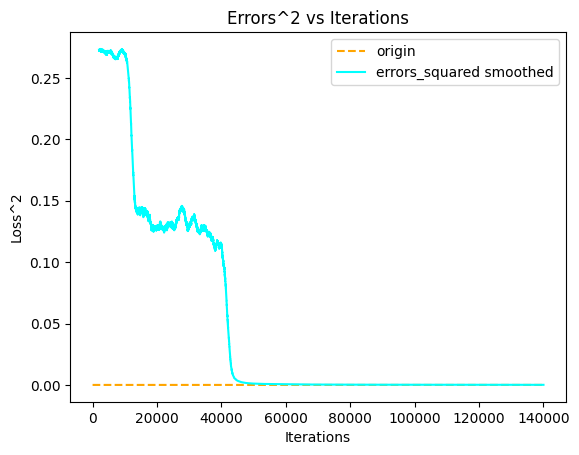

In [502]:
# Show smoothed loss function vs training steps
window_size = max(int(0.01*steps), 1)
errors_squared, smoothed_errors = nn.get_smoothed_errors_squared(window_size)
errors_squared = errors_squared.flatten()
num_errors = len(errors_squared)
x_errors = np.linspace(0, num_errors, num_errors)
x_smoothed = np.linspace(window_size, num_errors, len(smoothed_errors))
origin = np.zeros(num_errors)
plt.plot(x_errors, origin, '--', label='origin', color='orange')
# plt.plot(x_errors, errors_squared, label="errors_squared raw", color='blue')
plt.plot(x_smoothed, smoothed_errors, label="errors_squared smoothed", color='cyan')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss^2")
plt.title("Errors^2 vs Iterations")
plt.show()
plt.close()

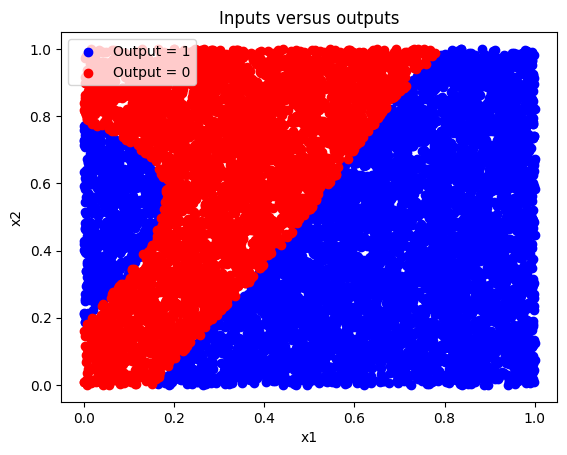

In [503]:
boundary = nn.visual_NN_boundaries(10000)
inputs, outputs = zip(*boundary)
inputs = np.vstack(inputs)
outputs = np.round(np.vstack(outputs)).astype(int).flatten()
true_inputs, false_inputs = inputs[outputs == 1], inputs[outputs == 0]
plt.scatter(true_inputs[:, 0], true_inputs[:, 1], c='b', marker='o', label='Output = 1')
plt.scatter(false_inputs[:, 0], false_inputs[:, 1], c='r', marker='o', label='Output = 0')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Inputs versus outputs")
plt.legend()
plt.show()
plt.close()